In [1]:
import _pickle as cPickle #guarda el modelo..
from IPython.display import Latex
import tensorflow as tf
import numpy as np
import pandas as pd 
import random
random.seed(0)
import matplotlib.pyplot as plt
import heapq
tf.compat.v1.disable_eager_execution()

paper: https://arxiv.org/ftp/arxiv/papers/1205/1205.2618.pdf

in consecutive update steps is small. We suggest to
use a bootstrap sampling approach with replacement
because stopping can be performed at any step. Abandoning the idea of full cycles through the data is especially useful in our case as the number of examples
is very large and for convergence often a fraction of a
full cycle is sufficient. We choose the number of single steps in our evaluation linearly depending on the
number of observed positive feedback S.

ç

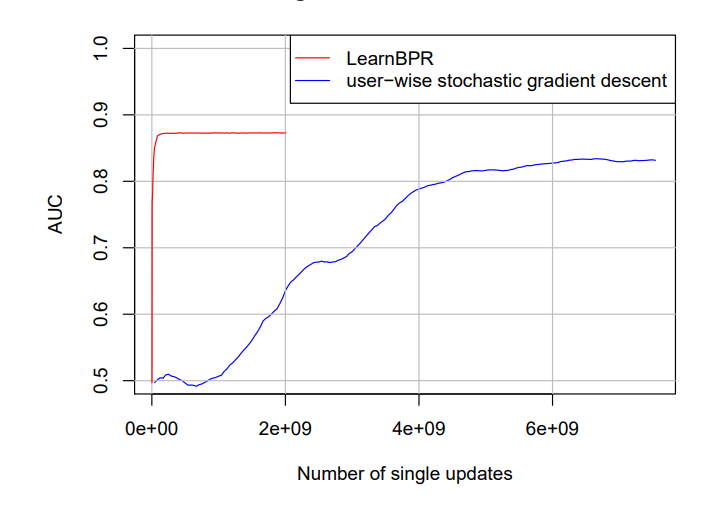

random en usuario, random en item con feedback, se contruye 1 elemento random. Así se evitan u,i,j consecutivas. 

426, 612 es a 2* 10**9 luego para 11k se recomiendad 51 M

## BPR

In [2]:
class DIS():
    def __init__(self, itemNum, userNum, emb_dim, lamda, param=None, initdelta=0.05, learning_rate=0.05):
        self.itemNum = itemNum
        self.userNum = userNum
        self.emb_dim = emb_dim
        self.lamda = lamda  # regularization parameters
        self.param = param
        self.initdelta = initdelta
        self.learning_rate = learning_rate
        self.d_params = []

        with tf.compat.v1.compat.v1.variable_scope('discriminator'):
            if self.param is None: #Si no hay param -> inicializacion aleatoria
                self.user_embeddings = tf.compat.v1.Variable(
                    tf.compat.v1.random_uniform([self.userNum, self.emb_dim], minval=-self.initdelta, maxval=self.initdelta,
                                      dtype=tf.compat.v1.float32))
                self.item_embeddings = tf.compat.v1.Variable(
                    tf.compat.v1.random_uniform([self.itemNum, self.emb_dim], minval=-self.initdelta, maxval=self.initdelta,
                                      dtype=tf.compat.v1.float32))
                self.item_bias = tf.compat.v1.Variable(tf.compat.v1.zeros([self.itemNum]))
            else: #lee los parametros del archivo
                self.user_embeddings = tf.compat.v1.Variable(self.param[0])
                self.item_embeddings = tf.compat.v1.Variable(self.param[1])
                self.item_bias = tf.compat.v1.Variable(self.param[2])

        self.d_params = [self.user_embeddings, self.item_embeddings, self.item_bias]

        # placeholder definition
        self.u = tf.compat.v1.placeholder(tf.compat.v1.int32)
        self.pos = tf.compat.v1.placeholder(tf.compat.v1.int32)
        self.neg = tf.compat.v1.placeholder(tf.compat.v1.int32)

        self.u_embedding = tf.compat.v1.nn.embedding_lookup(self.user_embeddings, self.u)
        self.pos_embedding = tf.compat.v1.nn.embedding_lookup(self.item_embeddings, self.pos)
        self.pos_bias = tf.compat.v1.gather(self.item_bias, self.pos)
        self.neg_embedding = tf.compat.v1.nn.embedding_lookup(self.item_embeddings, self.neg)
        self.neg_bias = tf.compat.v1.gather(self.item_bias, self.neg)

        self.pre_logits = tf.compat.v1.sigmoid(
            tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.pos_embedding - self.neg_embedding),
                          1) + self.pos_bias - self.neg_bias) #
        
        self.reg=  + self.lamda * (
            tf.compat.v1.nn.l2_loss(self.u_embedding) +
            tf.compat.v1.nn.l2_loss(self.pos_embedding) +
            tf.compat.v1.nn.l2_loss(self.pos_bias) +
            tf.compat.v1.nn.l2_loss(self.neg_embedding) +
            tf.compat.v1.nn.l2_loss(self.neg_bias)
        )

        self.pre_loss = -tf.compat.v1.reduce_mean(tf.compat.v1.log(self.pre_logits)) +self.reg
        d_opt = tf.compat.v1.train.GradientDescentOptimizer(self.learning_rate)
        self.d_updates = d_opt.minimize(self.pre_loss, var_list=self.d_params)

        # for test stage, self.u: [batch_size]
        self.all_rating = tf.compat.v1.matmul(self.u_embedding, self.item_embeddings, transpose_a=False,
                                    transpose_b=True) + self.item_bias

        self.all_logits = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.item_embeddings), 1) + self.item_bias
        # for dns sample
        self.dns_rating = tf.compat.v1.reduce_sum(tf.compat.v1.multiply(self.u_embedding, self.item_embeddings), 1) + self.item_bias

    def save_model(self, sess, filename):
        param = sess.run(self.d_params)
        cPickle.dump(param, open(filename, 'wb'))  #antes w

## Lectura Amazon 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

#workdir = '/content/drive/MyDrive/dataset_ml/amazon_men_actualizado/' 
workdir = '/content/drive/MyDrive/dataset_ml/women/' 

usuarios_train = np.load(workdir+'dic_train_women.npy',allow_pickle='TRUE')
usuarios_train=list(usuarios_train.reshape(-1,1))[0][0]
usuarios_test = np.load(workdir+'dic_test_women.npy',allow_pickle='TRUE')
usuarios_test=list(usuarios_test.reshape(-1,1))[0][0]
#DIS_TRAIN_FILE = "dis-train.txt"
#DIS_MODEL_FILE =   "model_dns.pkl" #rutaaaa

Mounted at /content/drive


In [4]:
user_pos_test = {}
user_pos_train= {}
c_t=0
all_items= []


for u in usuarios_train.keys():
  for item in usuarios_train[u]:
    if item[b"productid"] not in all_items:
      all_items.append(item[b"productid"])
    
    if u not in user_pos_train: #nuevo
      user_pos_train[u] = [item[b"productid"]]
    else: #sino agrego
      user_pos_train[u].append(item[b"productid"])
all_user= list(user_pos_train.keys())

for u in usuarios_train.keys():    
  item=usuarios_test[u][0]
  if item[b"productid"] not in all_items:
    c_t+=1
  else:
    user_pos_test[u] = [item[b"productid"]]

ITEM_NUM=len(all_items)
USER_NUM= len(usuarios_train.keys())

In [5]:
print("% de items en test que no estan en train: ",c_t/len(all_items)*100)
print("n item: ", ITEM_NUM, "n usuarios: ", USER_NUM)

% de items en test que no estan en train:  2.7743271221532093
n item:  7245 n usuarios:  3158


## Inicialiazacion DNS

bpr tal que se toma (u,i,j) comn j random, tripletas unicas, tal vez habría que considerar más tripletas para usuarios random y varios j para cada i.

In [6]:
def AUC(rating, test_users,dict_tov):
  """
  para cada usuario cuenta cuantos items de una muestra aleatoria tiene rating menor a 
  al rating del item consumido en test
  """
  ans=0
  cc=0
  for user in test_users:
      user_ind= test_users.index(user)
      user_= all_user[user]
      if dict_tov[user_][0] in all_items: #ignora el coldstart
          item_test= list(all_items).index(dict_tov[user_][0])
          cc+=1
          items_train= [ list(all_items).index(i) for i in user_pos_train[user_]]  
          no_considerar= set(items_train+ [item_test]) 
          count=0
          tmpans=0 
          for j in random.sample(range(ITEM_NUM),int(50*(len(no_considerar)-1))): #sample
              if j in no_considerar: continue
              if rating[user_ind,item_test]>rating[user_ind,j]: tmpans+=1
              count+=1

          tmpans/=float(count)
          ans+=tmpans
  
  ans/=float(cc)
  return ans



def simple_test(sess, model, dict_tov): 
  #Calcula AUC para todos los usuarios comparada con el elemento que quedo en el test set
  #dict_tov: test o validacion
 test_users=[ all_user.index(i) for i in dict_tov.keys()]
 user_batch_rating = sess.run(model.all_rating, {model.u: test_users}) 
 batch_result= AUC(user_batch_rating,test_users, dict_tov)
    
 return batch_result

In [7]:
list_dim= [10,20,35,50,75,100]
resultados=[]

In [12]:
for m in [0]:
  tf.compat.v1.reset_default_graph()
  param = None
  discriminator = DIS(ITEM_NUM, USER_NUM, 10, lamda=0.001, param=param, initdelta=0.1, learning_rate=0.1) #se llama al discriminador DNS


  config = tf.compat.v1.ConfigProto()
  config.gpu_options.allow_growth = True
  sess = tf.compat.v1.Session(config=config)
  sess.run(tf.compat.v1.global_variables_initializer())

  best_AUC=simple_test(sess, discriminator, user_pos_train) 
  #print("auc discriminador inicializado random", best_AUC)
  losses=[]
  aucs=[]
  for epoch in range(10000): #80 antes
    u= np.random.choice(list(user_pos_train.keys()), 1)[0]
    pos = user_pos_train[u] 
    candidates = list(set(all_items) - set(pos) )
    u= all_user.index(u)
    i=list(all_items).index(np.random.choice(pos,1))
    j= list(all_items).index(np.random.choice(candidates,1))
      #se actualiza el discriminador para la nueva tripleta
    _ ,loss= sess.run([discriminator.d_updates, discriminator.pre_loss ],
                                  feed_dict={discriminator.u: [u], discriminator.pos: [i],
                                            discriminator.neg: [j]})
    if epoch%50==0:   
      losses.append(loss)       
      AUC_actual = simple_test(sess, discriminator,user_pos_train) #evalua
      #print ("epoch ", epoch, "dis: ", AUC_actual, "loss:" , loss) 
      aucs.append(AUC_actual)
        
      if AUC_actual> best_AUC:
              #print("mejore")
              best_AUC = AUC_actual
              #discriminator.save_model(sess, DIS_MODEL_FILE)
      
      #print ("best AUC: ", best_AUC)
  resultados.append(best_AUC)
  print(best_AUC)

0.7108478792184583


In [ ]:
print(resultados)

[0.6464079932665201, 0.657678264851837, 0.6607664006418282, 0.6797142988485707, 0.6853519124110471, 0.6966391658440251]


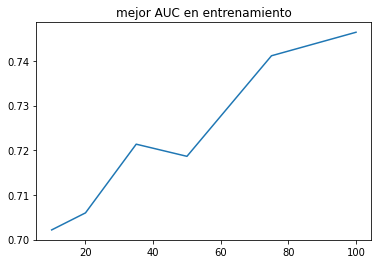

In [9]:
plt.plot(list_dim,resultados)
plt.title("mejor AUC en entrenamiento")
plt.show()

In [13]:
print(simple_test(sess, discriminator,user_pos_test))

0.8355325340809534


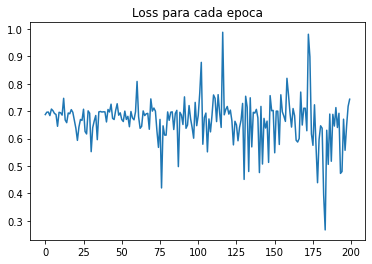

In [14]:
plt.plot(range(len(losses)),losses)
plt.title("Loss para cada epoca")
plt.show()

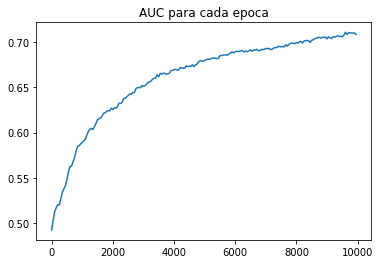

In [15]:
plt.plot([i*50 for i in range(len(aucs)) ], aucs)
plt.title("AUC para cada epoca")
plt.show()

In [ ]:
textfile = open(workdir+"bpr.txt", "w")
textfile.write(str(losses) + "\n")
textfile.write(str(aucs) + "\n")
textfile.close()